In [61]:
import torch
from tqdm import tqdm
import yaml
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from torch.autograd.variable import Variable
import matplotlib.pyplot as plt

config = {'batch_size': 320, 'epochs': 200, 'img_size': 28, 'latent_dim': 100, 'lr': 0.0002, 'num_channels': 1}

img_dims = (config['num_channels'], config['img_size'], config['img_size'])
num_features = config['num_channels'] * config['img_size'] * config['img_size']

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        def gan_layer(input_num, output_num, dropout=False):
            model = [nn.Linear(input_num, output_num)]
            model.append(nn.LeakyReLU(0.2, inplace=True))
            if dropout:
                model.append(nn.Dropout(0.25))
            return model

        self.model = nn.Sequential(
            *gan_layer(config['latent_dim'], 128, dropout=False),
            *gan_layer(128, 256, dropout=True),
            *gan_layer(256, 512, dropout=True),
            *gan_layer(512, 1024, dropout=True),
            nn.Linear(1024, num_features),
            nn.Tanh()
        )

    def forward(self, input):
        output_img = self.model(input)
        output_img = output_img.view(output_img.size(0), *img_dims)
        return output_img

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, img):
        img_flattened = img.view(img.size(0), -1)
        prob = self.model(img_flattened)
        return prob

def data_loader():
    compose = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))]
    )
    output_dir = './data/mnist'

    data = datasets.MNIST(root=output_dir, train=True,
                          transform=compose, download=True)
    dataloader = DataLoader(data, shuffle=True, batch_size=config['batch_size'], num_workers=2, pin_memory=True)
    return dataloader

if __name__ == '__main__':
    dataloader = data_loader()
    cuda = torch.cuda.is_available()
    tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

    loss = nn.BCELoss()
    generator = Generator()
    discriminator = Discriminator()

    discriminator_opt = optim.Adam(discriminator.parameters(), lr = config['lr'], betas=(0.5, 0.999))
    generator_opt = optim.Adam(generator.parameters(), config['lr'], betas=(0.5, 0.999))

    if cuda:
        generator = generator.cuda()
        discriminator = discriminator.cuda()
    
    for epoch in tqdm(range(config['epochs']), desc='Epoch'):
        for i, (img_batch, label_batch) in enumerate(dataloader):

            real = Variable(tensor(img_batch.size(0), 1).fill_(1), requires_grad=False)
            fake = Variable(tensor(img_batch.size(0), 1).fill_(0), requires_grad=False)

            real_img = Variable(img_batch.type(tensor))
            noise = Variable(tensor(img_batch.size(0), config['latent_dim']).normal_(0, 1))
            fake_img = Variable(generator(noise), requires_grad=False)

            discriminator_opt.zero_grad()

            discriminator_loss = loss(discriminator(real_img), real) + loss(discriminator(fake_img), fake)

            discriminator_loss.backward()
            discriminator_opt.step()
            
            # Generator update
            noise = Variable(tensor(img_batch.size(0), config['latent_dim']).normal_(0, 1))
            fake_imgs = generator(noise)

            generator_opt.zero_grad()
            generator_loss = loss(discriminator(fake_imgs), real)
            generator_loss.backward()
            generator_opt.step()


Epoch: 100%|██████████| 200/200 [34:08<00:00, 10.24s/it]


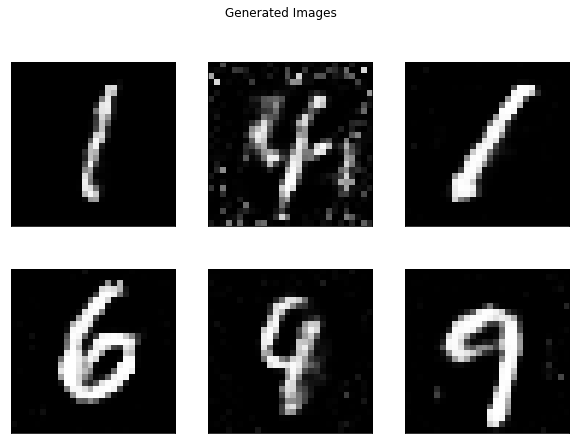

In [63]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10,7))
fig.suptitle('Generated Images')
for i in range(6):
    gen_img = fake_img[i, 0].detach().cpu()
    ax[i//3, i%3].imshow(gen_img, cmap='gray', vmin=-1, vmax=1)
    ax[i//3, i%3].set_xticks([]), ax[i//3, i%3].set_yticks([])